## Predicting Customer Churn using Feed-Forward Neural Networks

### Import Required Libraries

In [2]:
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset, Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration

### 1.1 Read the dataset

In [3]:
df = pd.read_csv('churn_dataset.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 1.2 Check for missing values

In [4]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### 1.3 Exploratory Data Analysis

1.3.1 Correlation Heatmap

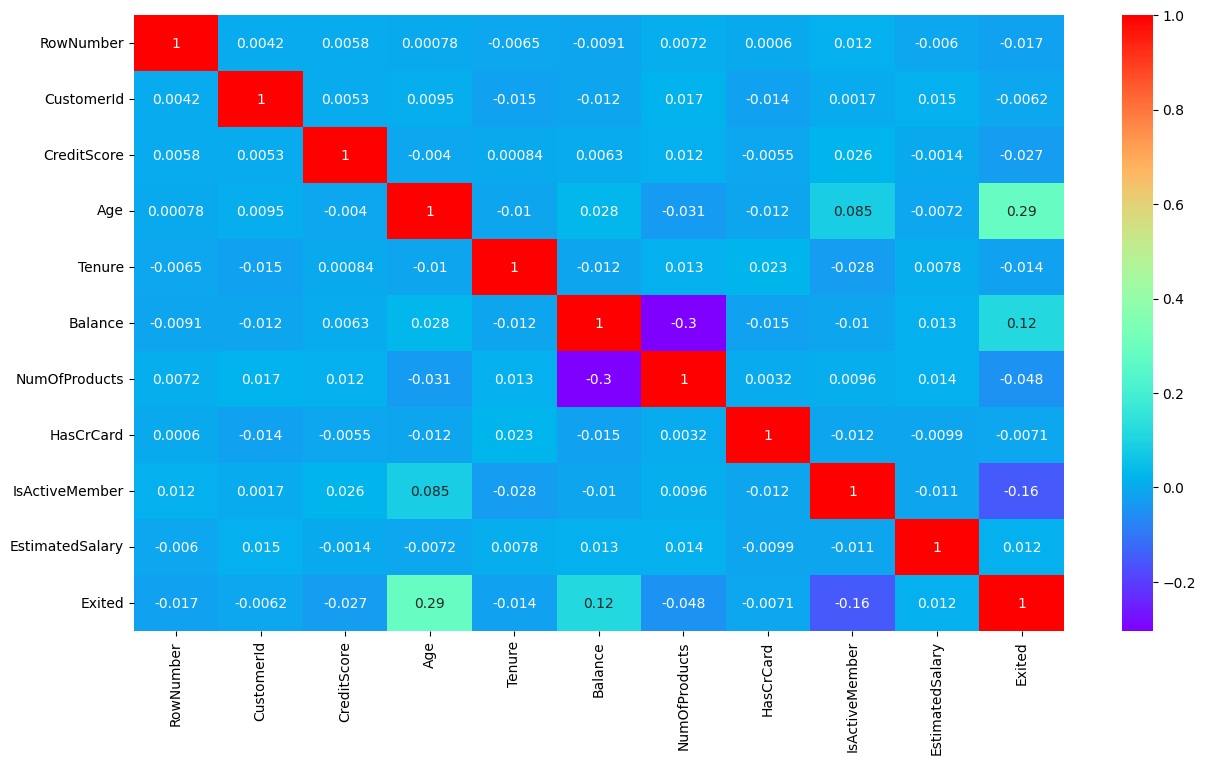

In [5]:
# Correlation heatmap
plt.figure(figsize=(15,8))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix,annot= True,cmap = 'rainbow')
plt.show()

1.3.2 Distribution of Balance

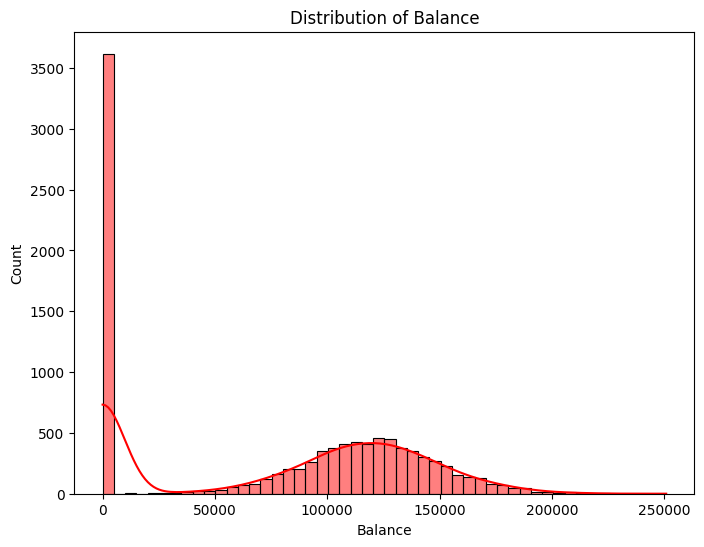

In [6]:
plt.figure(figsize=(8,6))
sns.histplot(df['Balance'],kde = True,bins=50, color='red')
plt.title('Distribution of Balance')
plt.show()

1.3.3 Distribution of the Estimated Salary of the user

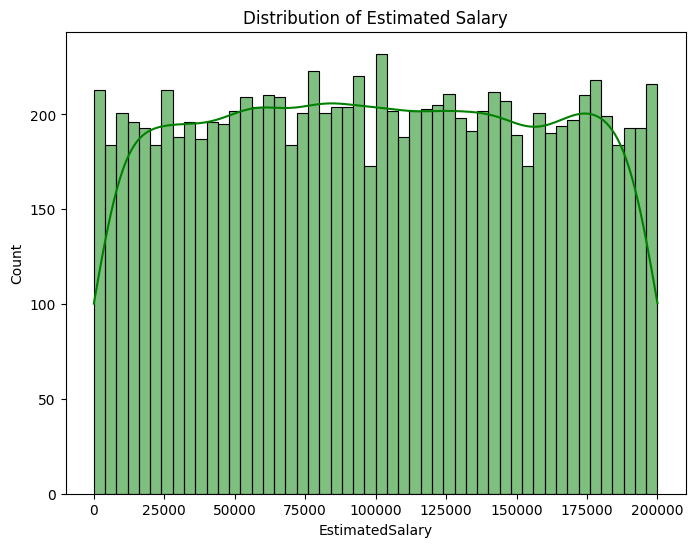

In [7]:
plt.figure(figsize=(8,6))
sns.histplot(df['EstimatedSalary'],kde = True,bins=50, color='green')
plt.title('Distribution of Estimated Salary')
plt.show()

1.3.4 Distribution of the customer's age

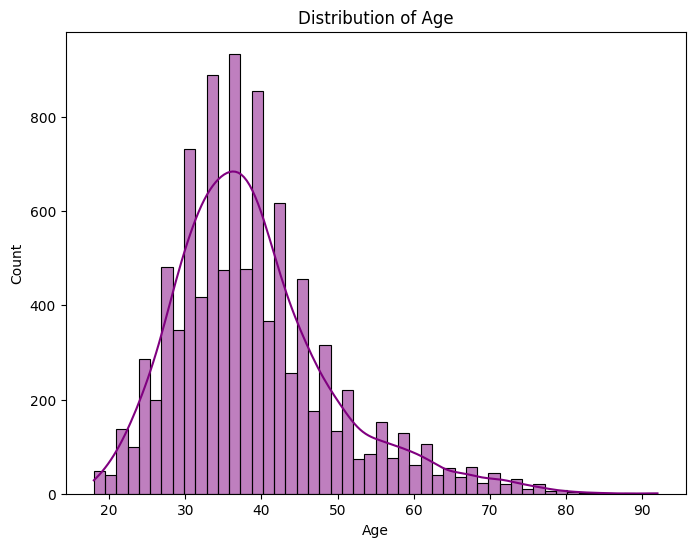

In [8]:
plt.figure(figsize=(8,6))
sns.histplot(df['Age'],kde = True,bins=50, color='purple')
plt.title('Distribution of Age')
plt.show()

1.3.5 Distribution for the number of products

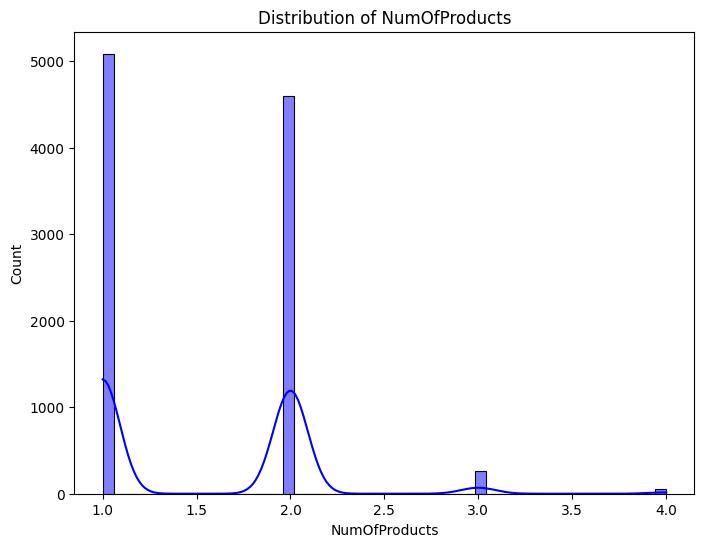

In [9]:
plt.figure(figsize=(8,6))
sns.histplot(df['NumOfProducts'],kde = True,bins=50, color='blue')
plt.title('Distribution of NumOfProducts')
plt.show()

1.3.6 Boxplots to check for outliers

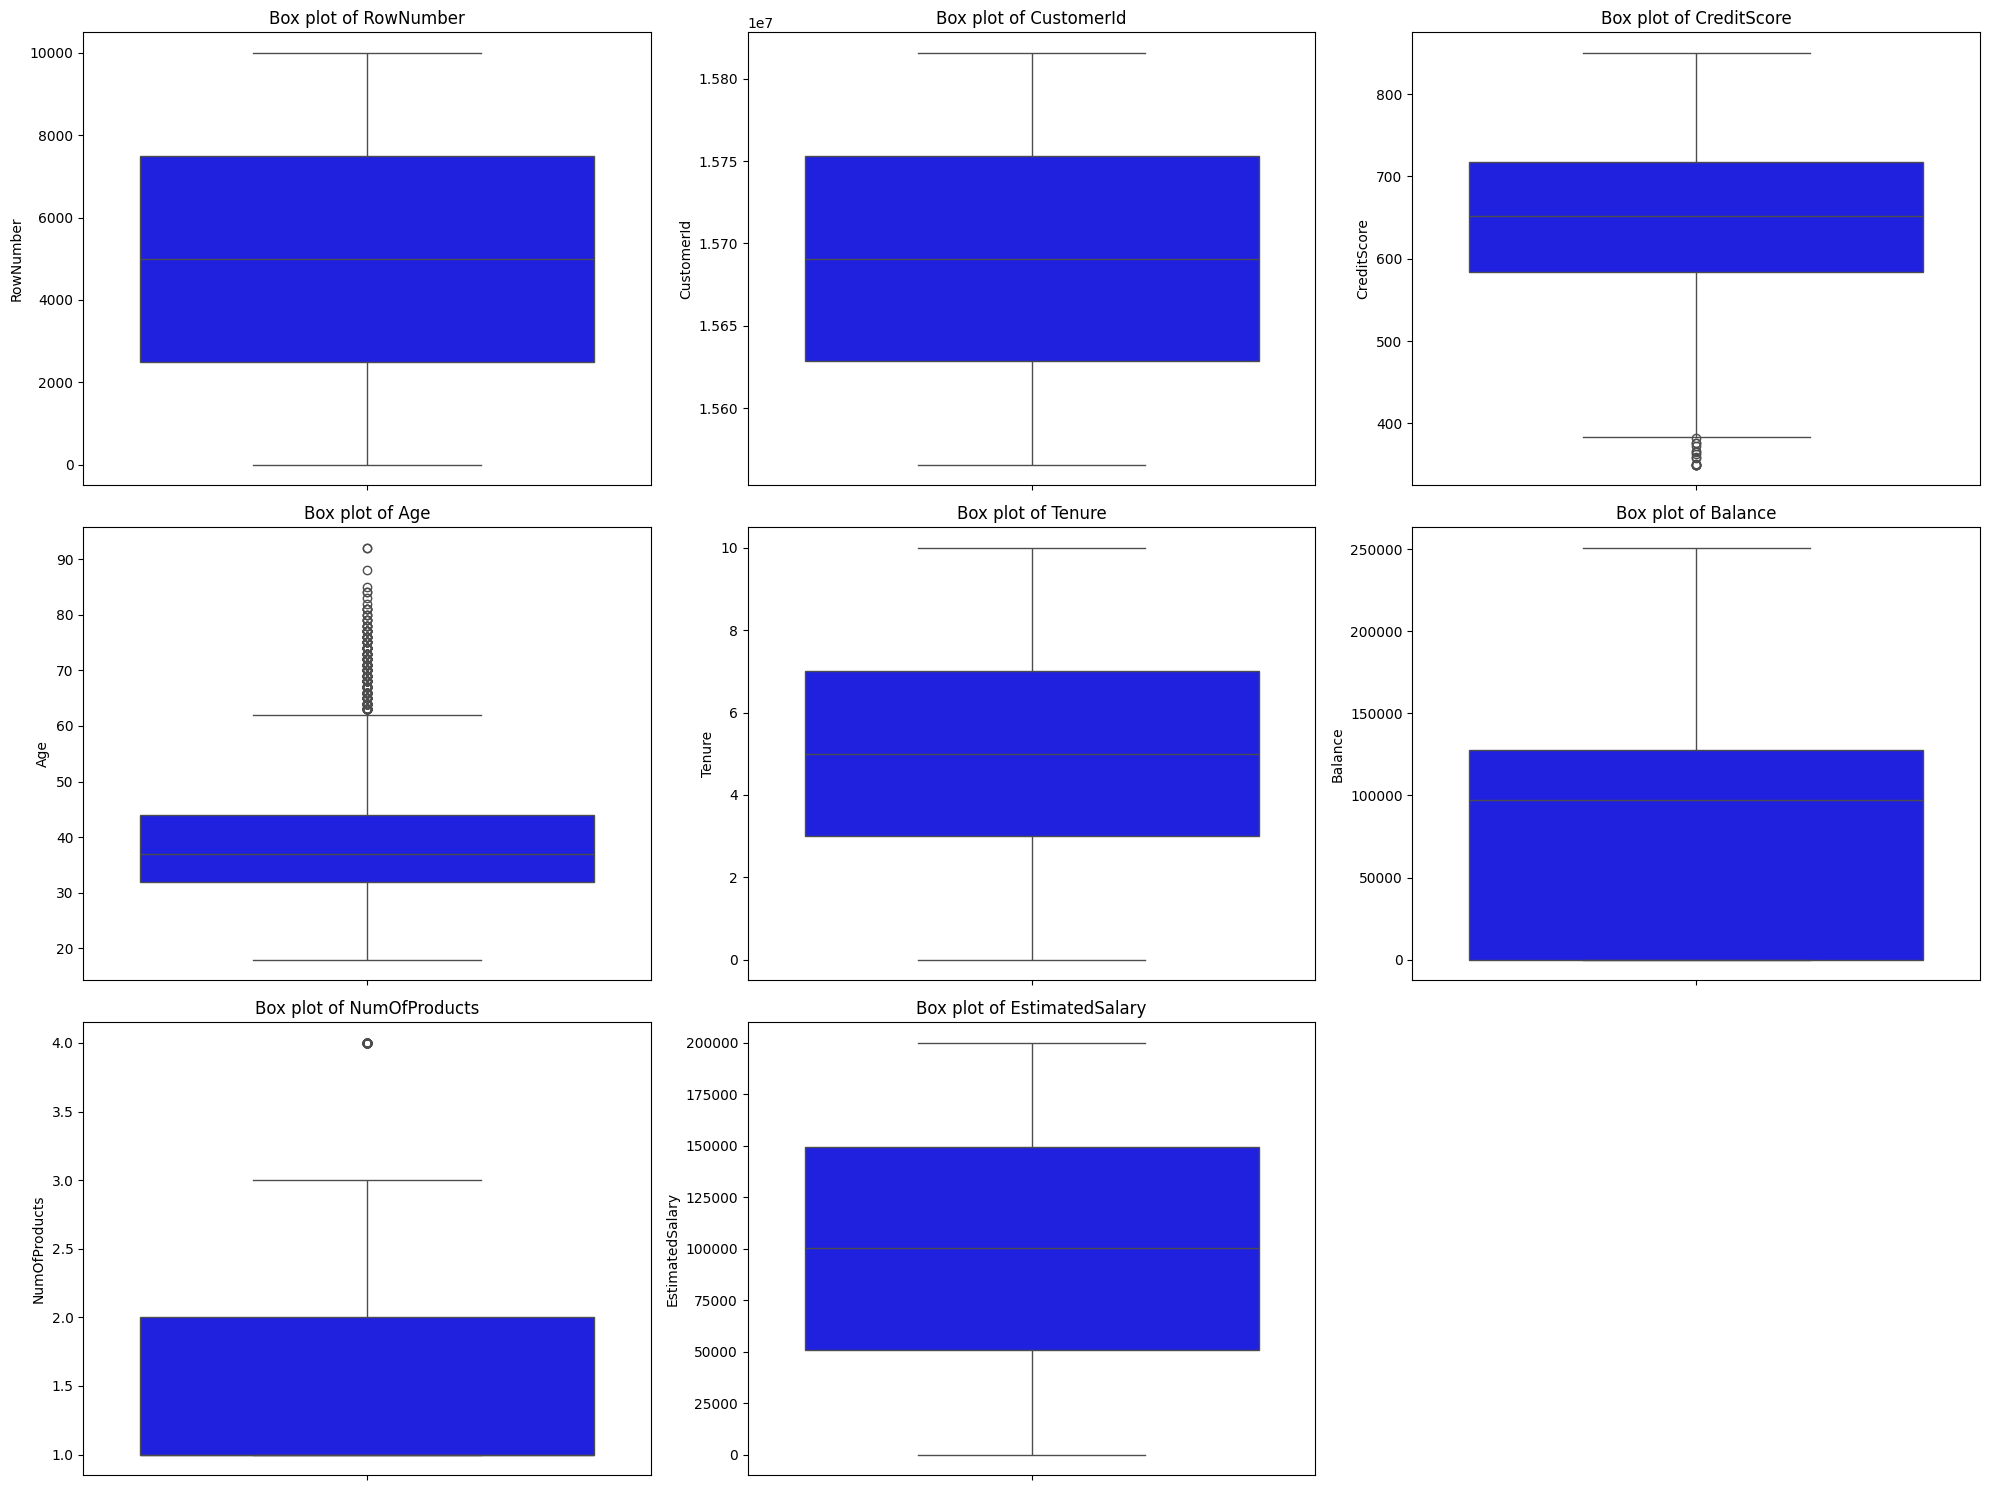

In [10]:
numerical_features = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in ['Exited', 'HasCrCard','IsActiveMember']]


plt.figure(figsize=(20, 15)) 
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features)//3 + 1,3, i)
    sns.boxplot(y=df[feature], color='blue')
    plt.title(f'Box plot of {feature}')
plt.tight_layout()
plt.show()

1.3.7 Distribution of Churned and Not churned customers

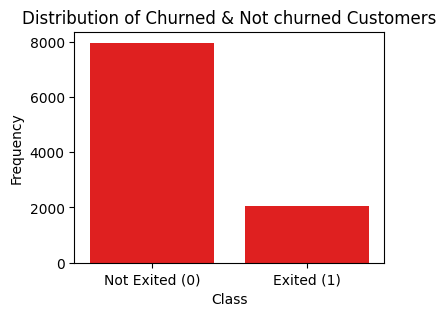

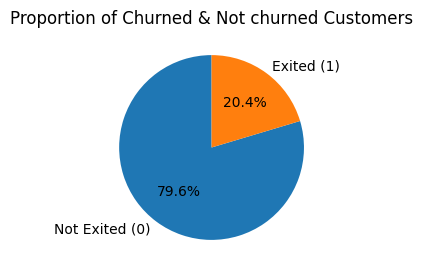

In [11]:
# Count the occurrences of each class
class_counts = df['Exited'].value_counts()

#Create a bar plot
plt.figure(figsize=(4,3))
sns.barplot(x=class_counts.index, y=class_counts.values, color='red')
plt.title('Distribution of Churned & Not churned Customers')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(len(class_counts)), ['Not Exited (0)', 'Exited (1)'])  # Assuming 0 and 1 are your class labels
plt.show()

#Same data as a pie chart 
plt.figure(figsize=(4,3))
plt.pie(class_counts, labels=['Not Exited (0)', 'Exited (1)'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Churned & Not churned Customers')
plt.show()

## 2. Split the data

Split into train, validation, and test set using Stratified Splits

In [12]:
## Stratified split on Target variable (Exited)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=123)
for train_index, eval_index in split.split(df, df["Exited"]):
    train = df.loc[train_index]
    eval = df.loc[eval_index]

train.reset_index(drop=True, inplace=True)
eval.reset_index(drop=True, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=123)
for test_index, val_index in split.split(eval, eval["Exited"]):
    val = eval.loc[test_index]
    test = eval.loc[val_index]

val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

## 3. Data Preprocessing

### 3.1 Onehot encoding for categorical variables

In [13]:
def one_hot_encoder(df, column):
    categories = pd.get_dummies(df[column], prefix=column)
    df = df.drop(column, axis=1)
    df = df.join(categories)
    return df


cols_to_encode = ['Geography','Gender']
for col in cols_to_encode:
    train = one_hot_encoder(train, col)
    val = one_hot_encoder(val, col)
    test = one_hot_encoder(test, col)

### 3.2 Drop columns that are not required (id columns)

In [14]:
def drop_columns(df, columns):
    df = df.drop(columns, axis=1)
    return df

columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']

train = drop_columns(train, columns_to_drop)
val = drop_columns(val, columns_to_drop)
test = drop_columns(test, columns_to_drop)

### 3.3 Separate the target variable and features

In [15]:
X_train = train.drop('Exited', axis=1)
y_train = train['Exited']

X_val = val.drop('Exited', axis=1)
y_val = val['Exited']

X_test = test.drop('Exited', axis=1)
y_test = test['Exited']

## 4. Handling Class Imbalance

In [16]:
smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

y_train.value_counts(), y_resampled.value_counts()

(Exited
 0    5574
 1    1426
 Name: count, dtype: int64,
 Exited
 0    5574
 1    5574
 Name: count, dtype: int64)

## 5. Standardizing the Dataset

In [17]:
scaler = StandardScaler()

X_std = scaler.fit_transform(X_resampled)

X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

In [18]:
X_train_std_df = pd.DataFrame(X_std, columns=X_train.columns)
X_val_std_df = pd.DataFrame(X_val_std, columns=X_val.columns)
X_test_std_df = pd.DataFrame(X_test_std, columns=X_test.columns)

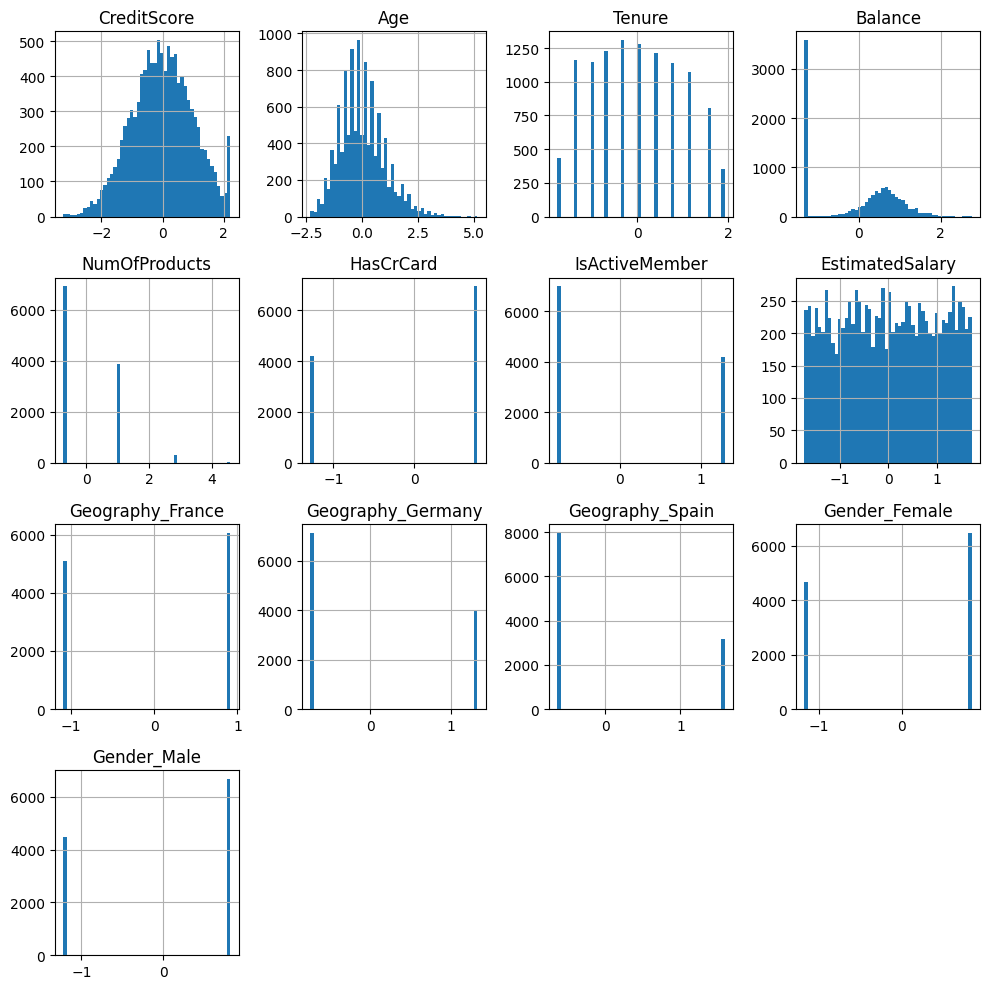

In [19]:
X_train_std_df.hist(figsize=(10, 10), bins=50)
plt.tight_layout()
plt.show()

## 6. Data Setup for training the neural network using Pytorch

### 6.1 Convert the data to tensors

In [20]:
X_train_tensor = torch.tensor(X_train_std_df.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val_std_df.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test_std_df.values.astype(np.float32))

y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values.astype(np.float32)).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

### 6.2 Create a custom data loader for Pytorch

In [21]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [22]:
train_dataset  = CustomDataset(X_train_tensor, y_train_tensor)
validation_dataset = CustomDataset(X_val_tensor, y_val_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

batch_size = 64

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True,num_workers = 0)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = 0)

## 7. Model Architecture Experiments

In this project, I am experimenting with 5 different architectures for the neural network:

1. Basic Neural Network
2. Neural Network with Dropout Layers
3. Adding L2 Regularization
4. Batch Normalization
5. Varying Layer Sizes and Depths

For activation functions, I am trying 4 different functions:

1. ReLU
2. Leaky ReLU
3. Tanh
4. Sigmoid

### 7.0 First, setup the device to use GPU if available

In [23]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### 7.1 Basic Neural Network

In [24]:
class FNN1_Basic(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super().__init__()
        self.activation = activation
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 1024),
            self.activation,
            nn.Linear(1024, 1024),
            self.activation,
            nn.Linear(1024, 1024),
            self.activation,
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        prediction = self.linear_relu_stack(x)
        return prediction

### 7.2 Adding Dropout layers

In [25]:
class FNN2_Dropout(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super().__init__()
        self.activation = activation
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 1024),
            self.activation,
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            self.activation,
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            self.activation,
            nn.Dropout(0.5),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        prediction = self.linear_relu_stack(x)
        return prediction

### 7.3 Adding L2 Regularization

In [26]:
class FNN3_L2Reg(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super().__init__()
        self.activation = activation
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 1024),
            self.activation,
            nn.Linear(1024, 1024),
            self.activation,
            nn.Linear(1024, 1024),
            self.activation,
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        prediction = self.linear_relu_stack(x)
        return prediction

### 7.4 Batch Normalization

In [27]:
class FNN4_BatchNorm(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super().__init__()
        self.activation = activation
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 1024),
            nn.BatchNorm1d(1024),
            self.activation,
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            self.activation,
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            self.activation,
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        prediction = self.linear_relu_stack(x)
        return prediction

### 7.5 Varying Layer sizes and depths

In [28]:
class FNN5_VaryLayer(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super().__init__()
        self.activation = activation
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 512),
            self.activation,
            nn.Linear(512, 256),
            self.activation,
            nn.Linear(256, 128),
            self.activation,
            nn.Linear(128, 1),
        )

    def forward(self, x):
        prediction = self.linear_relu_stack(x)
        return prediction

## 8. Creating Model Experiments with combinations of network architecture, activation function, & learning rates

For learning rate, I am experimenting 3 different values - 0.01, 0.1, 0.5

So combining this with the model architecture and activation functions, I am creating 60 experiments (5 architectures, 4 activation functions and 3 learning rates)

### 8.1 Create a list to initialize all model experiments

In [29]:
architectures = [FNN1_Basic(), FNN2_Dropout(), FNN3_L2Reg(), FNN4_BatchNorm(), FNN5_VaryLayer()]
architectures_names = ['FNN1_Basic', 'FNN2_Dropout', 'FNN3_L2Reg', 'FNN4_BatchNorm', 'FNN5_VaryLayer']

activation_fns = [nn.ReLU(), nn.LeakyReLU(0.01), nn.Tanh(), nn.Sigmoid()]
activation_fns_names = ['ReLU', 'LeakyReLU', 'Tanh', 'Sigmoid']

learning_rates = [0.01, 0.1, 0.5]

In [30]:
model_list = []
optimizers = []

for arch in architectures:
    for act_fn in activation_fns:
        for lr in learning_rates:
            model = arch
            model.activation = act_fn
            model.to(device)
            if arch==FNN3_L2Reg():
                optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.01)
            else:
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            model_list.append(model)
            optimizers.append(optimizer)

Print the Architecture for the first model

In [31]:
print(model_list[0])

FNN1_Basic(
  (activation): Sigmoid()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=13, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1, bias=True)
  )
)


### 8.2 Define the model training & validation loops

In [32]:
batch_size = 512
num_epochs = 100
loss_fn = nn.BCEWithLogitsLoss()

In [33]:
def train_loop(dataloader, model, loss_fn, optimizer, print_loss):

    train_losses = []
    
    total_loss = 0
    total_count = 0
    size = len(dataloader.dataset)
    model.train()
    for batch,(X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        #Backpropagation 
        optimizer.zero_grad()
        
        #Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        total_count += X.size(0)
            
    average_loss = total_loss / total_count
    train_losses.append(average_loss)
    if print_loss==True:
        print(f"Loss: {round(average_loss, 4)}")
    return train_losses

#Validation loop
def validation_loop(dataloader, model, loss_fn,print_loss):
    total_loss = 0
    total_count = 0

    val_losses = []
    val_accuracy = []
    all_pred_labels = []
    all_true_labels = []

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss , correct = 0 , 0

    with torch.no_grad():
        for X, y in dataloader:
            #Move data to same device as the model 
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            if y.dim() == 1:
                y = y.unsqueeze(1)  

            loss = loss_fn(pred, y)  
            total_loss += loss.item() * X.size(0) 
            total_count += X.size(0)
            
            pred_labels = torch.sigmoid(pred) > 0.5
            correct += (pred_labels == y).type(torch.float).sum().item()
            
            all_pred_labels.append(pred_labels.cpu())
            all_true_labels.append(y.cpu())
        
    average_loss = total_loss / total_count
    val_losses.append(average_loss)
    val_accuracy.append(100*correct/total_count)

    if print_loss==True:
        print(f"On Validation Set - Loss: {round(average_loss, 4)}, Accuracy: {round((100*correct/total_count),2)}% \n")

    return val_losses, val_accuracy

In [34]:
results_df = pd.DataFrame(columns=['Exp No', 'Model Architecture', 'Activation Function', 'Learning Rate', 'Avg Training Loss', 'Avg Validation Loss', 'Avg Validation Accuracy'])

In [35]:
print_freq = 20
for i in range(len(model_list)):
    train_loss_arr = []
    val_loss_arr = []
    val_accuracy_arr = []
    for t in range(num_epochs):       
        print_loss = False 
        if (t % print_freq == 0) & (i%20==0):
            print(f"Epoch {t} for Experiment {i+1}")
            print_loss = True
        train_losses = train_loop(train_loader,model_list[i],loss_fn,optimizers[i], print_loss)
        val_losses, val_accuracies = validation_loop(validation_loader,model_list[i],loss_fn, print_loss)
        train_loss_arr.append(train_losses)
        val_loss_arr.append(val_losses)
        val_accuracy_arr.append(val_accuracies)

    # Calculate averages of losses and accuracies
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

    # Save the results to DataFrame
    arch_index = i // (len(activation_fns) * len(learning_rates))  
    act_index = (i // len(learning_rates)) % len(activation_fns) 
    lr_index = i % len(learning_rates) 
    new_row = pd.DataFrame({
        'Exp No': i+1,
        'Model Architecture': architectures_names[arch_index],
        'Activation Function': activation_fns_names[act_index],
        'Learning Rate': learning_rates[lr_index],
        'Avg Training Loss': avg_train_loss,
        'Avg Validation Loss': avg_val_loss,
        'Avg Validation Accuracy': avg_val_accuracy
    }, index=[0])

    results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_loss_arr) + 1), train_loss_arr, label='Training Loss')
    plt.plot(range(1, len(val_loss_arr) + 1), val_loss_arr, label='Validation Loss')
    plt.title(f'Training and Validation Loss - Model {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'plots/Loss_Model_{i+1}.png')
    plt.close()

    # Plot the validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(val_accuracy_arr) + 1), val_accuracy_arr, label='Validation Accuracy')
    plt.title(f'Accuracy on Validation Set - Model {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'plots/Accuracy_Model_{i+1}.png')
    plt.close()


# Save the results to a CSV file
results_df.to_csv('model_performance.csv', index=False)

Epoch 0 for Experiment 1
Loss: 0.5356
On Validation Set - Loss: 0.4833, Accuracy: 79.6% 

Epoch 20 for Experiment 1
Loss: 0.361
On Validation Set - Loss: 0.3637, Accuracy: 85.47% 

Epoch 40 for Experiment 1
Loss: 0.3244
On Validation Set - Loss: 0.3355, Accuracy: 86.47% 

Epoch 60 for Experiment 1
Loss: 0.308
On Validation Set - Loss: 0.3552, Accuracy: 84.6% 

Epoch 80 for Experiment 1
Loss: 0.2943
On Validation Set - Loss: 0.3293, Accuracy: 86.27% 

Epoch 0 for Experiment 21
Loss: 0.1544
On Validation Set - Loss: 0.6512, Accuracy: 83.0% 

Epoch 20 for Experiment 21
Loss: 0.1865
On Validation Set - Loss: 0.5693, Accuracy: 82.4% 

Epoch 40 for Experiment 21
Loss: 0.1745
On Validation Set - Loss: 0.5793, Accuracy: 83.0% 

Epoch 60 for Experiment 21
Loss: 0.1749
On Validation Set - Loss: 0.5988, Accuracy: 83.0% 

Epoch 80 for Experiment 21
Loss: 0.159
On Validation Set - Loss: 0.638, Accuracy: 82.07% 

Epoch 0 for Experiment 41
Loss: 0.0275
On Validation Set - Loss: 0.9797, Accuracy: 81.5

## 9. Visualize the training and validation loss, accuracy over epochs

The plots for each experiment are saved in the plots folder. Displaying the results for the first experiment here.

### 9.1 Training vs Validation loss over epochs

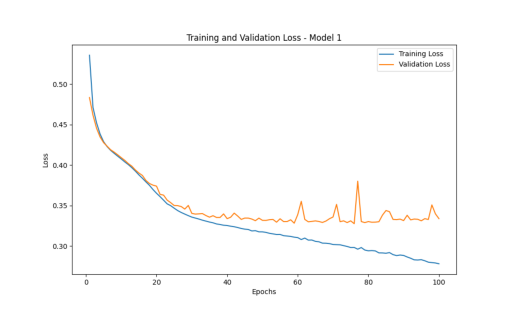

In [38]:
image_path = 'plots/Loss_Model_1.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off') 
plt.show()

### 9.2 Validation accuracy over epochs

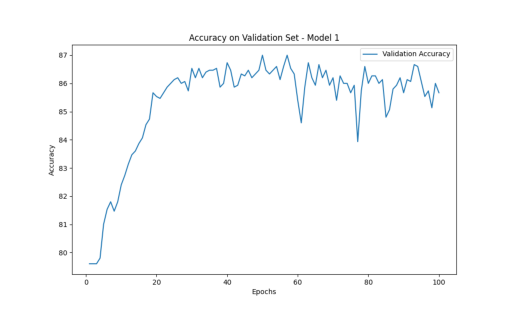

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = 'plots/Accuracy_Model_1.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off') 
plt.show()

## 10. Finding the best model & calculating metrics for test data

### 10.1 Find the best model based on highest validation set accuracy

In [44]:
best_exp = results_df.loc[results_df['Avg Validation Accuracy'].idxmax()]
best_exp

Exp No                               13
Model Architecture         FNN2_Dropout
Activation Function                ReLU
Learning Rate                      0.01
Avg Training Loss              0.354117
Avg Validation Loss            0.335273
Avg Validation Accuracy            87.0
Name: 12, dtype: object

### 10.2 Calculate predictions for the test set

In [52]:
model = model_list[best_exp['Exp No']-1]
model.to(device)

model.eval()  
with torch.no_grad():
    test_tensor = X_test_tensor.to(device)
    predictions_logits = model(test_tensor)
    predictions_prob = torch.sigmoid(predictions_logits)
    predictions = (predictions_prob > 0.5).float()

# Convert the predictions tensor to a numpy array
y_pred = predictions.cpu().numpy().flatten()

### 10.3 Calculate evaluation metrics for the test set

Accuracy: 82.0%
Precision: 0.5618
Recall: 0.5213
F1 Score: 0.5408


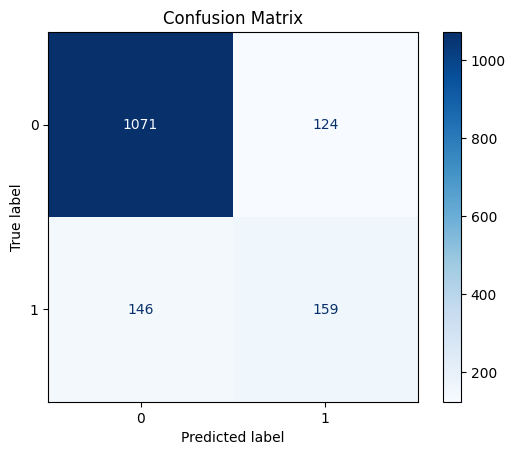

In [55]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {round(100*accuracy,2)}%")
print(f"Precision: {round(precision,4)}")
print(f"Recall: {round(recall,4)}")
print(f"F1 Score: {round(f1,4)}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()